In [27]:
from typing import Optional

from einops import rearrange
import sigpy as sp
import sigpy.mri as mri
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchkbnufft import KbNufft, KbNufftAdjoint

def spiral_2d(N=128, n_shots: Optional[int] = 16, alpha: Optional[float] = 1.5) -> np.ndarray:
    """
    Generates an 2-dimensional variable density spiral

    Parameters:
    ----------
    n_shots : int
        number of phase encodes to cover k-space
    alpha : float
        controls variable density. 1.0 means no variable density, center denisty increases with alpha

    Returns:
    ----------
    trj : np.ndarray <float>
        k-space trajector with shape (n_read_spi, n_shots, d), d = len(self.im_size)
    """

    # Gen spiral
    trj = mri.spiral(
        fov=1,
        N=N,
        f_sampling=0.4, # TODO function of self.n_read
        R=1,
        ninterleaves=n_shots,
        alpha=alpha,
        gm=0.4, # Tesla / m
        sm=10, # Tesla / m / s
    )
    assert trj.shape[0] % n_shots == 0
    trj = trj.reshape((trj.shape[0] // n_shots, n_shots, 2), order='F')

    # Equalize axes
    # for i in range(trj.shape[-1]):
    #     trj[..., i] *= N / 2 / trj[..., i].max()

    return trj

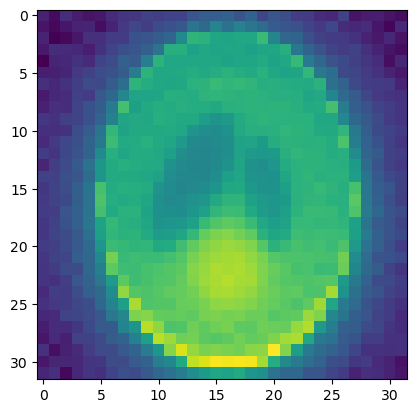

In [28]:
%matplotlib inline
trj = spiral_2d()
img = sp.shepp_logan((128, 128)).astype(np.complex64)
ksp = sp.nufft(img, trj)
img2 = sp.nufft_adjoint(ksp, trj, oshape=(32, 32))
plt.imshow(np.abs(img2))


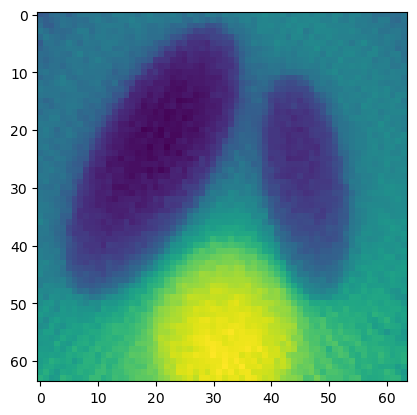

In [41]:
x = torch.from_numpy(img).to(torch.complex64)
omega = rearrange(trj, 'k r d -> d (r k)') * np.pi / (img.shape[0]/2)
omega = torch.from_numpy(omega).to(torch.float32)
nufft = KbNufft((128, 128))
nufft_adjoint = KbNufftAdjoint((64, 64))

ksp = nufft(x[None, None], omega)
y = nufft_adjoint(ksp, omega)[0, 0]
plt.imshow(np.abs(y.detach().cpu().numpy()))

In [34]:
omega.max()


3.1169728973739073